# PyTorch - Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domain

In this notebook we try to reproduce the work "Fourier Features Let Networks Learn
High Frequency Functions in Low Dimensional Domain" using PyTorch.

Yeah, I know that there are several implementations around using PyTorch, Tensorflow, etc, but I wanted to do it myself to understand the paper better,
and I think I'll make it leaner and more readable than the others.

**Disclaimer**: The goal is just to learn a bit more about this feature expansion technique, and yes, I'm overfitting the training data.

Follow below the code 

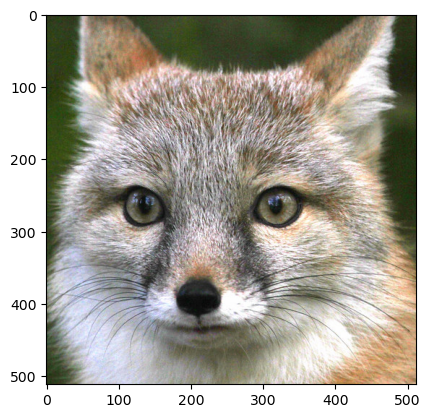

In [108]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

def download_image():
    # Using the same function from the original paper repository (https://github.com/tancik/fourier-feature-networks)
    image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    image = imageio.imread(image_url)[..., :3] / 255.
    c = [image.shape[0] // 2, image.shape[1] // 2]
    r = 256
    image = image[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

    return image.astype(np.float32)

image = download_image()
plt.imshow(image)

## Create the inputs and the network

First we create the $(x,y)$ inputs of the network that corresponds to the image coordinates scaled to be in the range [0, 1] x [0, 1].
Then the network that it is a simple 3-layer MLP with 256 hidden units and LeakyReLUs activations.


![](nn.png)

Text(0.5, 1.0, 'Y coordinates')

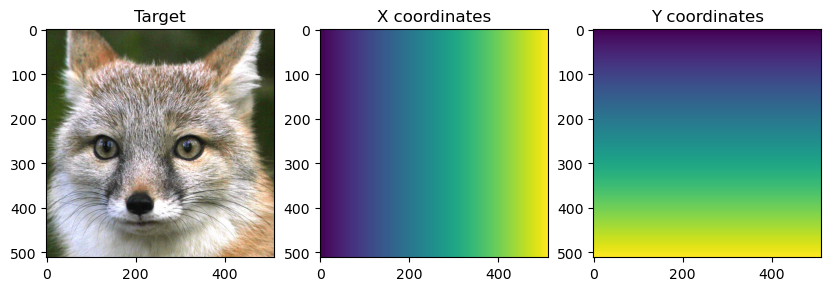

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_nn_input(image):

    # Creating the target image BxCxHxW
    target = torch.tensor(image).unsqueeze(0).permute(0, 3, 1, 2).to(device)

    # Create input pixel coordinates
    unit_coordinates = np.linspace(0, 1, target.shape[2], endpoint=False)
    xy_coordinates = np.stack(np.meshgrid(unit_coordinates, unit_coordinates), -1)
    xy_coordinates = torch.tensor(xy_coordinates).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

    return xy_coordinates, target


def create_simple_model(device, num_input_channels=2):    

    return nn.Sequential(
            nn.Conv2d(
                num_input_channels,
                256,
                kernel_size=1,
                padding=0),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(
                256,
                256,
                kernel_size=1,
                padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(
                256,
                3,
                kernel_size=1,
                padding=0),
            nn.Sigmoid(),

        ).to(device)

def training_loop(model, optimizer, xy_grid, target, epochs=400):
    # Vanilla training loop with MSE loss
    model.train()
    loss_history = []
    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()

        generated = model(xy_grid)

        loss = torch.nn.functional.mse_loss(target, generated)
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

    return model, loss_history

xy_coordinates, target = create_nn_input(image)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(target[0].permute(1, 2, 0).cpu().detach().numpy())
ax[0].set_title('Target')
ax[1].imshow(xy_coordinates[0,0].cpu().detach().numpy())
ax[1].set_title('X coordinates')
ax[2].imshow(xy_coordinates[0,1].cpu().detach().numpy())
ax[2].set_title('Y coordinates')

## Implementing the Fourier Mapping.

According to section 6 of the paper, we can use different mappings $\gamma(\mathbf{v})$. Hence, we have implemented


- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$


In [110]:
class FourierFeatureTransform(torch.nn.Module):
    def __init__(self, mapping="none", mapping_dim=128, scale=10, device="cpu"):
        super().__init__()
        self.mapping_dim = mapping_dim
        self.mapping = mapping
        if mapping == "basic":
            self.B = torch.eye(2)
            # Setting the device
            self.B = self.B.to(device)
            self.mapping_dim = 2

        elif mapping == "gaussian":
            self.B = torch.randn((2, mapping_dim)) * scale
            # Setting the device
            self.B = self.B.to(device)

        else:
            self.B = None

    def forward(self, x):
        if self.B is None:
            return x

        # Project to the sphere
        batches, channels, width, height = x.shape

        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)
        project = (2 * torch.pi * x) @ self.B

        # F**k, for some reason that I don't know yet I have to reshape this like this instead
        # of using a simple reshape with the final format
        #project = project.reshape(batches, self.mapping_dim, width, height)
        project = project.reshape(batches, width, height, self.mapping_dim)

        # From [B, W, H, C] to [B, C, W, H]
        project = project.permute(0, 3, 1, 2)
        
        project = torch.cat([torch.sin(project), torch.cos(project)], dim=1)

        return project


## Training with no mapping

We train the network with no mapping and we plot the results.
We can see that the network is not able to learn the high frequency details of the target image.

Input shape: torch.Size([1, 2, 512, 512])
Target shape: torch.Size([1, 3, 512, 512])


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:18<00:00, 22.08it/s]


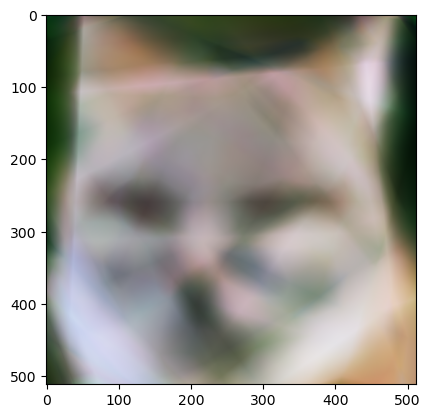

In [114]:

epochs = 400
xy_coordinates, target = create_nn_input(image)
xy_coordinates = FourierFeatureTransform()(xy_coordinates)


print(f"Input shape: {xy_coordinates.shape}")
print(f"Target shape: {target.shape}")

model = create_simple_model(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

model, no_mapping_loss = training_loop(model, optimizer, xy_coordinates, target, epochs=epochs)
model.eval()
no_mapping = model(xy_coordinates).detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(no_mapping)


## Training with basic mapping

We train the network with basic mapping and we plot the results.
We can see that the network was able to learn the high frequency details of the target image a bit better, but it is still blurry.

Input shape: torch.Size([1, 4, 512, 512])
Target shape: torch.Size([1, 3, 512, 512])


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


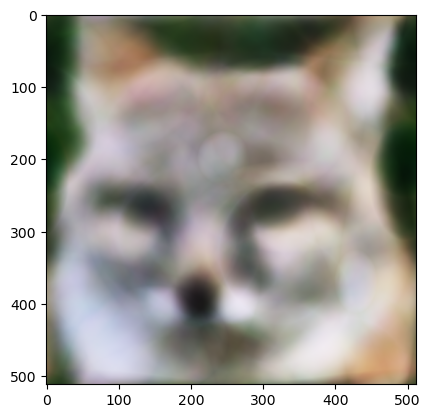

In [116]:
epochs = 400
xy_coordinates, target = create_nn_input(image)
xy_coordinates = FourierFeatureTransform(mapping="basic", device=device)(xy_coordinates)


print(f"Input shape: {xy_coordinates.shape}")
print(f"Target shape: {target.shape}")

model =create_simple_model(device, num_input_channels=4)
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

model, basic_mapping_loss = training_loop(model, optimizer, xy_coordinates, target, epochs=epochs)
model.eval()
basic_mapping = model(xy_coordinates).detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(basic_mapping)


## Gaussian feature mapping

We train the network with Gaussian feature mapping and we plot the results.
We can see that the network was able to learn the high frequency details of the target even image better than the two other methods.
Amazing!

Input shape: torch.Size([1, 256, 512, 512])
Target shape: torch.Size([1, 3, 512, 512])


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:20<00:00, 19.54it/s]


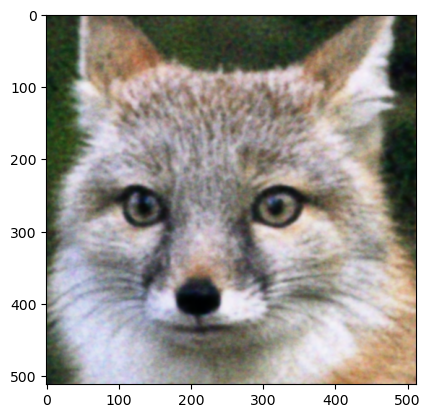

In [118]:
epochs = 400
xy_coordinates, target = create_nn_input(image)
xy_coordinates = FourierFeatureTransform(mapping="gaussian", device=device)(xy_coordinates)


print(f"Input shape: {xy_coordinates.shape}")
print(f"Target shape: {target.shape}")


model =create_simple_model(device, num_input_channels=256)
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

model, gaussian_loss = training_loop(model, optimizer, xy_coordinates, target, epochs=epochs)
model.eval()
gaussian_mapping = model(xy_coordinates).detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(gaussian_mapping)

## Comparing the generated images of each method

Text(0.5, 1.0, 'Target')

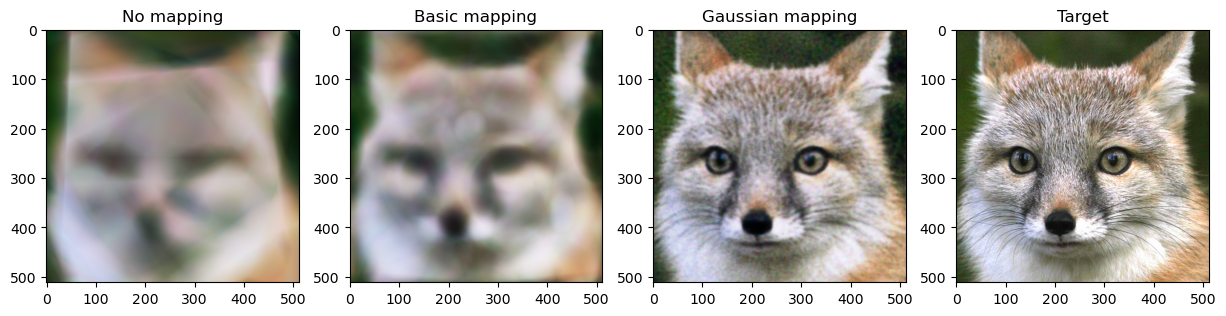

In [122]:
# Plotting the three images

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(no_mapping)
ax[0].set_title('No mapping')
ax[1].imshow(basic_mapping)
ax[1].set_title('Basic mapping')
ax[2].imshow(gaussian_mapping)
ax[2].set_title('Gaussian mapping')
ax[3].imshow(image)
ax[3].set_title('Target')

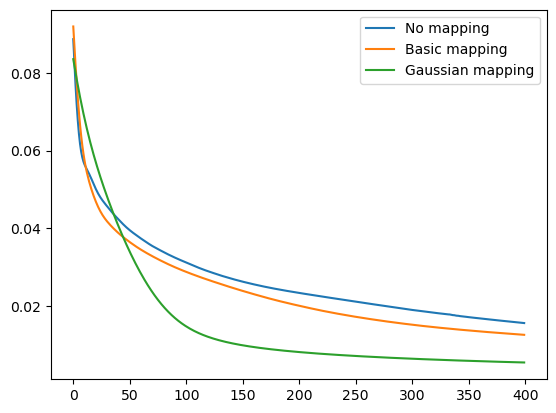

In [121]:
fig, ax = plt.subplots(1, 1)
ax.plot(no_mapping_loss, label="No mapping")
ax.plot(basic_mapping_loss, label="Basic mapping")
ax.plot(gaussian_loss, label="Gaussian mapping")
plt.legend()